In [1]:
%cd drive/MyDrive/Data/HW0/p1_data
# path = './drive/MyDrive/Data/HW0/p1_data/'

/content/drive/MyDrive/Data/HW0/p1_data


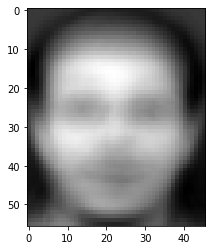

In [2]:
# 1.
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt

files = glob.glob('*.png')
files = [f.replace('.png', '').split('_') for f in files]
files = [[int(f[0]), int(f[1])] for f in files]
files.sort()
train_files = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] != 10]
test_files = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] == 10]
# find mean face
images = [Image.open(f) for f in train_files]
image_shape = np.array(images[0]).shape                     # (56, 46)
image_matrix = np.array([np.array(image).flatten() for image in images])  # (360, 2576)
mean_face_flatten = np.zeros(image_matrix.shape[1])
for i in range(image_matrix.shape[0]):
  mean_face_flatten += image_matrix[i]
mean_face_flatten /= image_matrix.shape[0]
mean_face = np.reshape(mean_face_flatten, image_shape)
plt.imshow(mean_face, cmap='gray')
plt.imsave('../result/mean_face.png', mean_face, cmap='gray')

diff_image_matrix = np.array([image - mean_face_flatten for image in image_matrix])         # (360, 2576)
cov_image_matrix = np.dot(diff_image_matrix, diff_image_matrix.T) / len(train_files)

e_values, e_vectors = np.linalg.eig(cov_image_matrix)
e_vectors = np.dot(e_vectors.T, diff_image_matrix)        # (360, 2576)
e_vectors = [e_vector / np.linalg.norm(e_vector) for e_vector in e_vectors]
e_indices = np.argsort(-e_values)
e_vectors = [e_vectors[e_indices[i]] for i, e_vector in enumerate(e_vectors)]

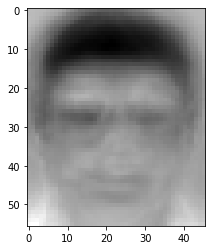

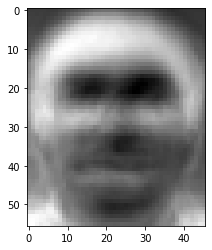

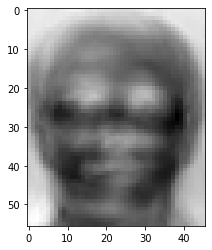

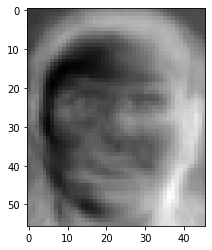

In [3]:
# plot eigenfaces
# print(np.dot(e_vectors[e_indices[0]], e_vectors[e_indices[9]]))
# plt.subplots()
for i in range(4):
  eigenface = np.reshape(e_vectors[i], image_shape)
  # plt.subplot(1, 4, i + 1)
  plt.figure()
  plt.imshow(eigenface, cmap='gray')
  plt.imsave(f'../result/eigenface{i}.png', eigenface, cmap='gray')

[1566.347198469649, 134.03183261341115, 39.8470405506107, 21.477817770862003, 3.042216175564511]


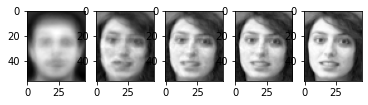

In [4]:
# 2. and 3.
def get_reconstruct_image(n, image_fn):
  image = np.array(Image.open(image_fn)) - mean_face
  image_shape = image.shape
  image = image.flatten()
  scalars = np.dot(e_vectors, image.T)
  eigenfaces = np.array(e_vectors[:n])
  scalars = np.array(scalars[:n])
  image_on_eigenspace = np.reshape(np.dot(eigenfaces.T, scalars), image_shape)
  return (image_on_eigenspace + mean_face) % 255



n = [3, 50, 170, 240, 345]

image = Image.open('8_1.png')
image = np.array(image)

recon_images = []
for j in n:
  recon_images.append(get_reconstruct_image(j, '8_1.png'))

mse_losses = []
plt.subplots()
for index, recon_image in enumerate(recon_images):
  mse_losses.append(np.square(recon_image - image).mean())
  plt.subplot(1, 5, index + 1)
  plt.imshow(recon_image, cmap='gray')
  plt.imsave(f'../result/recon_image{index}.png', recon_image, cmap='gray')
print(mse_losses)

In [16]:
scalars = {}
for f in files:
  fn = str(f[0]) + '_' + str(f[1]) + '.png'
  image = np.array(Image.open(fn)) - mean_face
  image = image.flatten()
  scalars[fn] = np.dot(e_vectors, image.T)

def knn_classifier(k, n, train_data, test_data):
  total = 0
  correct = 0
  for test_image_file in test_data:
    answer = test_image_file.split('_')[0]
    vote = {}
    MSE_losses = {}
    for train_image_file in train_data:
      test_image = scalars[test_image_file][:n]
      train_image = scalars[train_image_file][:n]
      MSE_losses[train_image_file] = np.linalg.norm(test_image - train_image)
    MSE_indices = np.argsort(list(MSE_losses.values()))
    MSE_keys = list(MSE_losses.keys())
    for j in range(k):
      cl = MSE_keys[MSE_indices[j]].split('_')[0]
      if cl in vote.keys():
        vote[cl] += 1
      else:
        vote[cl] = 1
    # print(vote)
    if len(list(vote.keys())) == k and k!= 1:
      solution = str(list(vote.keys())[0])
    else:
      vote_indices = np.argsort(list(vote.values()))
      vote_keys = list(vote.keys())
      solution = str(vote_keys[vote_indices[-1]])
    # print(solution)
    if answer == solution:
      correct += 1
    total += 1
  # print(f'correct = {correct}, total = {total}')
  return correct / total

In [17]:
# 4.
ks = [1, 3, 5]
ns = [3, 50, 170]
accuracy = np.zeros((3, 3))

for i, k in enumerate(ks):
  for j, n in enumerate(ns):
    acc = 0
    for m in range(3):
      # train_data = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] not in range(3 * m + 1, 3 * m + 4)]
      # test_data = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] in range(3 * m + 1, 3 * m + 4)]
      train_data = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] not in range(3 * m + 1, 3 * m + 4)]
      test_data = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] in range(3 * m + 1, 3 * m + 4)]
      acc += knn_classifier(k, n, train_data, test_data)
    accuracy[i, j] = acc / 3
    print(f'accuracy of ({k}, {n})={accuracy[i, j]}')

accuracy of (1, 3)=0.6805555555555555
accuracy of (1, 50)=0.9694444444444444
accuracy of (1, 170)=0.9583333333333334
accuracy of (3, 3)=0.5916666666666667
accuracy of (3, 50)=0.9194444444444446
accuracy of (3, 170)=0.9083333333333333
accuracy of (5, 3)=0.5388888888888889
accuracy of (5, 50)=0.8611111111111112
accuracy of (5, 170)=0.8416666666666667


In [7]:
# 5.
train_set = [str(f[0]) + '_' + str(f[1]) + '.png' for f in files if f[1] != 10]
# print(train_set)
test_set = test_files
# print(test_set)
accuracy_test = knn_classifier(1, 50, train_set, test_set)
print(accuracy_test)

0.925
